<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" title="Title text" width="20%" />

<hr style="height:2px;border:none"/>
<H1 align='center'> Redes Bayesianas </H1>

<H3> INF-396 Introducción a la Ciencia de Datos </H3>
<H3> Autor: Francisco Andrades</H3>

Lenguaje: Python

Temas:

    - Redes Bayesianas 
    - Inferencia

<hr style="height:2px;border:none"/>


Primero definiremos una red simple. La red define si cierto contenido, posiblemente dañino, en una red social debe ser eliminado de la red (R {1: contenido debe se eliminado, 0: no eliminado}) y si el usuario debe ser baneado (B {1: Usuario es baneado, 0: Usuario no es baneado}) utilizando la historia del usuario (H {1: Usuario ya fue baneado antes, 0: Usuario no ha sido baneado}), la salida de un modelo de machine learning que predice en base al texto del contenido si es que es dañino o no (M {1: Contenido dañino, 0: Contenido no dañino}) y la etiqueta de otros usuarios sobre si el contenido es dañino o no (U {1: Contenido dañino, 0: Contenido no dañino}). 

La red está definida por las siguientes CPD:

- P(U=1) = 0.15
- P(M=1) = 0.05
- P(H=1) = 0.1
- P(B=1|H=1,R=1) = 0.4 
- P(B=1|H=0,R=1) = 0.05 
- P(B=1|H=1,R=0) = 0.12
- P(B=1|H=0,R=0) = 0.02
- P(R=1|M=1,H=1,U=1) = 0.95 
- P(R=1|M=1,H=1,U=0) = 0.90 
- P(R=1|M=1,H=0,U=1) = 0.85 
- P(R=1|M=1,H=0,U=0) = 0.76 
- P(R=1|M=0,H=1,U=1) = 0.18 
- P(R=1|M=0,H=1,U=0) = 0.06 
- P(R=1|M=0,H=0,U=1) = 0.14 
- P(R=1|M=0,H=0,U=0) = 0.04

Independencias

Liste todas las independencias locales y liste todas las independencias markovianas globales para la variable R.

Conteste las siguientes consultas:
1. Encuentre la probabilidad de que cualquier contenido deba ser eliminado de la plataforma.
2. Encuentre la probabilidad de que el modelo deba ser removido de la plataforma dado que el modelo de machine learning lo etiquetó como dañino. ¿Cual es el patrón de razonamiento?
3. Encuentre la probabilidad de que el modelo haya sido etiquetado cómo dañino por otro usuario dado que se sabe que fué removido. ¿Cual es el patrón de razonamiento?
4. Encuentre la probabilidad de que el modelo haya sido etiquetado cómo dañino por otro usuario dado que se sabe fué removido y el modelo lo etiquetó cómo dañino. ¿Cual es el patrón de razonamiento?
5. Encuentre la probabilidad de que el usuario haya sido baneado anteriormente dado que se sabe que su contenido fué removido y que el modelo etiquetó el contenido cómo dañino. ¿Cual es el patrón de razonamiento?


In [1]:
#importamos librerías necesarias
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination

/home/leicasdayz/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Creamos la red 

In [2]:
model = BayesianModel([('U', 'R'), ('M', 'R'), ('H', 'R'), ('H', 'B'), ('R','B')])

In [3]:
## Definimos las CPD de acuerdo a la información dada

cpd_u = TabularCPD(variable='U', variable_card=2, values=[[0.85], [0.15]]) # [P(U=0),P(U=1)]
cpd_m = TabularCPD(variable='M', variable_card=2, values=[[0.95], [0.05]])
cpd_h = TabularCPD(variable='H', variable_card=2, values=[[0.9], [0.1]])

cpd_r = TabularCPD(variable='R', variable_card=2, 
                         #M0,H0,U0  M0,H0,U1  M0,H1,U0  M0,H1,U1  M1,H0,U0  M1,H0,U1  M1,H1,U0  M1,H1,U1
                   values=[[0.96,     0.86,     0.94,     0.82,     0.24,     0.15,     0.10,       0.05],
                           [0.04,     0.14,     0.06,     0.18,     0.76,     0.85,     0.90,       0.95]],
                  evidence=['M', 'H', 'U'],
                  evidence_card=[2, 2, 2])

cpd_b = TabularCPD(variable='B', variable_card=2, 
                           #H0,R0 H0,R1 H1,R0 H1,R1 
                   values=[[0.98, 0.95, 0.88, 0.6],
                           [0.02, 0.05, 0.12, 0.4]],
                  evidence=['H', 'R'],
                  evidence_card=[2, 2])

model.add_cpds(cpd_u, cpd_m, cpd_h, cpd_r, cpd_b)

In [4]:
print(cpd_u)

+------+------+
| U(0) | 0.85 |
+------+------+
| U(1) | 0.15 |
+------+------+


In [5]:
# Chequeo si el modelo es válido
model.check_model()


True

### Plot

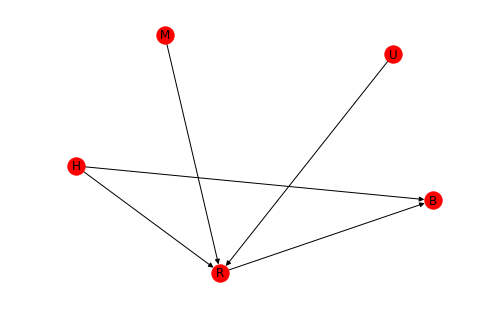

In [6]:
# PLOT  de la red
nx.draw(model, with_labels=True)
plt.show()


### Independencias Locales

In [7]:
#independencias locales
model.local_independencies(['U', 'M', 'H', 'R', 'B'])

(U _|_ H, M)
(M _|_ U, H)
(H _|_ U, M)
(B _|_ U, M | R, H)

### Independencias Globales de Markov

In [8]:
print(model.active_trail_nodes('R'))

{'R': {'B', 'M', 'R', 'U', 'H'}}


Es claro que R no puede ser independiente a ninguna variable, ya que tiene una relación directa con todas las otras variables.

### Consultas

##### 1.1

In [9]:
infer = VariableElimination(model)
g_dist = infer.query(['R'])
print(g_dist)

Eliminating: M: 100%|██████████| 4/4 [00:00<00:00, 66.12it/s]

+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.9062 |
+------+----------+
| R(1) |   0.0938 |
+------+----------+


La probabilidad de que cualquier contenido sea eliminado de la plataforma (R=1) es 0.0938

#### 1.2

In [10]:
print(infer.query(['R'], evidence={'M': 1}))

Eliminating: H: 100%|██████████| 3/3 [00:00<00:00, 85.88it/s]

+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.2131 |
+------+----------+
| R(1) |   0.7869 |
+------+----------+


La probabilidad de que el contenido deba ser eliminado dado que el modelo de ML lo etiquetó como dañino es 0.7869

#### 1.3

In [11]:
print(infer.query(['U'], evidence={'R': 1}))

Eliminating: M: 100%|██████████| 3/3 [00:00<00:00, 93.63it/s]

+------+----------+
| U    |   phi(U) |
+======+==========+
| U(0) |   0.7124 |
+------+----------+
| U(1) |   0.2876 |
+------+----------+


La probabilidad de que el contenido haya sido etiquetado como dañino por otro usuario, dado que se sabe fue removido es 0.2876

#### 1.4

In [12]:
print(infer.query(['U'], evidence={'R': 1,'M':1}))

Eliminating: H: 100%|██████████| 2/2 [00:00<00:00, 84.04it/s]

+------+----------+
| U    |   phi(U) |
+======+==========+
| U(0) |   0.8361 |
+------+----------+
| U(1) |   0.1639 |
+------+----------+


La probabilidad de que el contenido haya sido etiquetado como dañino por otro usuario, dado que se sabe fue removido y el modelo de ML lo etiquetó como dañino es 0.1639

#### 1.5

In [13]:
print(infer.query(['H'], evidence={'R': 1,'M':1}))

Eliminating: B: 100%|██████████| 2/2 [00:00<00:00, 182.14it/s]

+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.8847 |
+------+----------+
| H(1) |   0.1153 |
+------+----------+


La probabilidad de que el usuario haya sido baneado anteriormente, dado que se sabe que su contenido fue removido y el modelo de ML lo etiquetó como dañino es 0.1153